In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import json

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
df = pd.read_csv('/content/Cyber-Threat-Intelligence-Custom-Data_new_processed.csv')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
# Display basic information
df.head().T

,0,1,2,3,4
id,249,14309,13996,13600,14364
text,A cybersquatting domain save-russia[.]today is...,"Like the Android Maikspy, it first sends a not...",While analyzing the technical details of this ...,(Note that Flash has been declared end-of-life...,Figure 21. Connection of Maikspy variants to 1...
relations,"[{'from_id': 44658, 'id': 9, 'to_id': 44659, '...","[{'from_id': 48531, 'id': 445, 'to_id': 48532,...","[{'from_id': 48781, 'id': 461, 'to_id': 48782,...","[{'from_id': 51688, 'id': 1133, 'to_id': 51689...","[{'from_id': 51780, 'id': 1161, 'to_id': 44372..."
diagnosis,The diagnosis is a cyber attack that involves ...,The diagnosis is that the entity identified as...,Diagnosis: APT37/Reaper/Group 123 is responsib...,The diagnosis is a malware infection. The enti...,The diagnosis is that Maikspy malware variants...
solutions,1. Implementing DNS filtering to block access ...,1. Implementing a robust anti-malware software...,1. Implementing advanced threat detection tech...,1. Implementing a robust antivirus software th...,1. Implementing a robust firewall system that ...
id_1,44656,48530,48781,51687,51779
label_1,attack-pattern,SOFTWARE,threat-actor,TIME,URL
start_offset_1,2,9,188,62,163
end_offset_1,16,17,194,79,191
id_2,44657,48531,48782,51688,51777


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              476 non-null    int64  
 1   text            476 non-null    object 
 2   relations       476 non-null    object 
 3   diagnosis       475 non-null    object 
 4   solutions       476 non-null    object 
 5   id_1            476 non-null    int64  
 6   label_1         476 non-null    object 
 7   start_offset_1  476 non-null    int64  
 8   end_offset_1    476 non-null    int64  
 9   id_2            476 non-null    int64  
 10  label_2         476 non-null    object 
 11  start_offset_2  476 non-null    int64  
 12  end_offset_2    476 non-null    int64  
 13  id_3            329 non-null    float64
 14  label_3         329 non-null    object 
 15  start_offset_3  329 non-null    float64
 16  end_offset_3    329 non-null    float64
dtypes: float64(3), int64(7), object(7)


Handling Missing Values

In [18]:
# Check for null values
print(df.isnull().sum())

# Handle missing values
# For text columns, fill with empty string
text_columns = ['text', 'diagnosis', 'solutions']
for col in text_columns:
    df[col] = df[col].fillna('')

# For categorical columns, fill with 'unknown'
categorical_columns = ['label_1', 'label_2', 'label_3']
for col in categorical_columns:
    df[col] = df[col].fillna('unknown')

# For numerical columns, fill with median
numerical_columns = ['start_offset_1', 'end_offset_1', 'start_offset_2', 'end_offset_2']
for col in numerical_columns:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

id                  0
text                0
relations           0
diagnosis           1
solutions           0
id_1                0
label_1             0
start_offset_1      0
end_offset_1        0
id_2                0
label_2             0
start_offset_2      0
end_offset_2        0
id_3              147
label_3           147
start_offset_3    147
end_offset_3      147
dtype: int64


Feature Engineering
We'll create features from both the structured data and text data.

.1 Text Preprocessing

In [19]:
# Text cleaning function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Lemmatization function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def lemmatize_text(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply text cleaning
df['clean_text'] = df['text'].apply(clean_text)
df['clean_diagnosis'] = df['diagnosis'].apply(clean_text)
df['clean_solutions'] = df['solutions'].apply(clean_text)

# Combine all text features
df['combined_text'] = df['clean_text'] + ' ' + df['clean_diagnosis'] + ' ' + df['clean_solutions']

# Apply lemmatization
df['processed_text'] = df['combined_text'].apply(lemmatize_text)

.2 Structured Feature Extraction

In [21]:
# Extract threat types from labels
def extract_threat_type(row):
    labels = [row['label_1'], row['label_2'], row['label_3']]
    if 'malware' in labels:
        return 'malware'
    elif 'attack-pattern' in labels:
        return 'attack_pattern'
    elif 'vulnerability' in labels:
        return 'vulnerability'
    elif 'threat-actor' in labels:
        return 'threat_actor'
    else:
        return 'other'

df['threat_type'] = df.apply(extract_threat_type, axis=1)

# Extract severity from diagnosis (simple heuristic)
def extract_severity(diagnosis):
    diagnosis = diagnosis.lower()
    if 'critical' in diagnosis or 'severe' in diagnosis:
        return 'high'
    elif 'moderate' in diagnosis or 'medium' in diagnosis:
        return 'medium'
    else:
        return 'low'

df['severity'] = df['diagnosis'].apply(extract_severity)

# Extract solution count
df['solution_count'] = df['solutions'].apply(lambda x: len(x.split('.'))) - 1

# Extract text length features
df['text_length'] = df['text'].apply(len)
df['diagnosis_length'] = df['diagnosis'].apply(len)
df['solutions_length'] = df['solutions'].apply(len)

3 Target Variable Creation
We'll use the 'threat_type' as our target variable for classification.

In [22]:
# Encode the target variable
label_encoder = LabelEncoder()
df['threat_type_encoded'] = label_encoder.fit_transform(df['threat_type'])

# Display class distribution
print(df['threat_type'].value_counts())

threat_type
malware           225
attack_pattern     73
other              66
threat_actor       64
vulnerability      48
Name: count, dtype: int64


Feature Selection

In [23]:
# Text feature vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
text_features = tfidf_vectorizer.fit_transform(df['processed_text'])

# Structured features
structured_features = df[['solution_count', 'text_length', 'diagnosis_length', 'solutions_length']]

# Encode categorical features
severity_encoded = pd.get_dummies(df['severity'], prefix='severity')

# Combine all features
from scipy.sparse import hstack
X = hstack([text_features, structured_features, severity_encoded])
y = df['threat_type_encoded']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Model Training
We'll train several supervised models and compare their performance.

.1 Random Forest Classifier
python


In [24]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest Classifier:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Classifier:
                precision    recall  f1-score   support

attack_pattern       0.91      0.67      0.77        15
       malware       0.76      1.00      0.87        45
         other       0.86      0.46      0.60        13
  threat_actor       1.00      0.77      0.87        13
 vulnerability       0.78      0.70      0.74        10

      accuracy                           0.81        96
     macro avg       0.86      0.72      0.77        96
  weighted avg       0.83      0.81      0.80        96

Accuracy: 0.8125


 Support Vector Machine (SVM)

In [25]:
# SVM
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predictions
y_pred_svm = svm_model.predict(X_test)

# Evaluation
print("Support Vector Machine:")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

Support Vector Machine:
                precision    recall  f1-score   support

attack_pattern       0.67      0.67      0.67        15
       malware       0.83      0.89      0.86        45
         other       0.55      0.46      0.50        13
  threat_actor       0.90      0.69      0.78        13
 vulnerability       0.67      0.80      0.73        10

      accuracy                           0.76        96
     macro avg       0.72      0.70      0.71        96
  weighted avg       0.76      0.76      0.76        96

Accuracy: 0.7604166666666666


3 XGBoost Classifier

In [26]:
# XGBoost
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("XGBoost Classifier:")
print(classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))

XGBoost Classifier:
                precision    recall  f1-score   support

attack_pattern       0.82      0.60      0.69        15
       malware       0.79      0.93      0.86        45
         other       0.88      0.54      0.67        13
  threat_actor       0.82      0.69      0.75        13
 vulnerability       0.69      0.90      0.78        10

      accuracy                           0.79        96
     macro avg       0.80      0.73      0.75        96
  weighted avg       0.80      0.79      0.78        96

Accuracy: 0.7916666666666666


.4 Naive Bayes Classifier

In [27]:
# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predictions
y_pred_nb = nb_model.predict(X_test)

# Evaluation
print("Naive Bayes Classifier:")
print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))

Naive Bayes Classifier:
                precision    recall  f1-score   support

attack_pattern       0.43      0.20      0.27        15
       malware       0.46      0.82      0.59        45
         other       0.00      0.00      0.00        13
  threat_actor       0.33      0.23      0.27        13
 vulnerability       0.00      0.00      0.00        10

      accuracy                           0.45        96
     macro avg       0.24      0.25      0.23        96
  weighted avg       0.33      0.45      0.36        96

Accuracy: 0.4479166666666667


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model Evaluation and Selection


Random Forest Performance:
Accuracy: 0.8125
                precision    recall  f1-score   support

attack_pattern       0.91      0.67      0.77        15
       malware       0.76      1.00      0.87        45
         other       0.86      0.46      0.60        13
  threat_actor       1.00      0.77      0.87        13
 vulnerability       0.78      0.70      0.74        10

      accuracy                           0.81        96
     macro avg       0.86      0.72      0.77        96
  weighted avg       0.83      0.81      0.80        96


SVM Performance:
Accuracy: 0.7604166666666666
                precision    recall  f1-score   support

attack_pattern       0.67      0.67      0.67        15
       malware       0.83      0.89      0.86        45
         other       0.55      0.46      0.50        13
  threat_actor       0.90      0.69      0.78        13
 vulnerability       0.67      0.80      0.73        10

      accuracy                           0.76        96
     ma

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


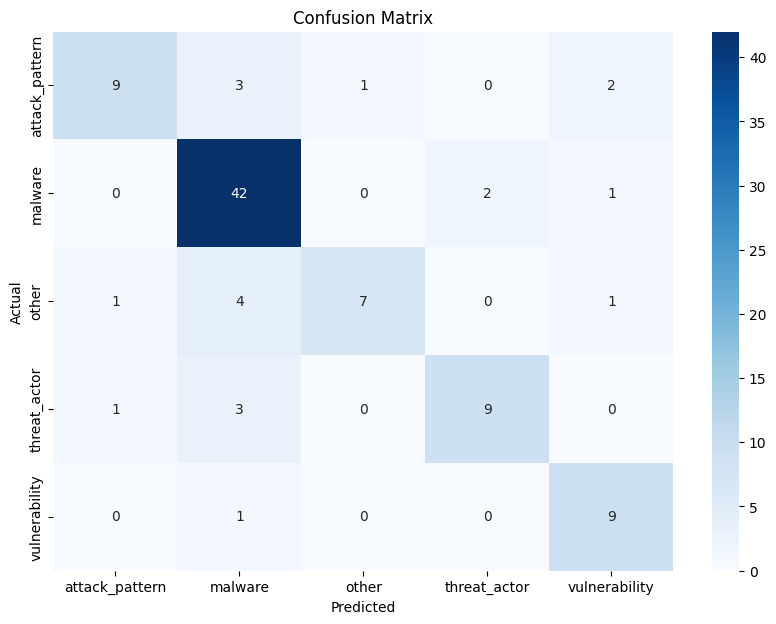

In [28]:
# Compare model performances
models = {
    'Random Forest': y_pred_rf,
    'SVM': y_pred_svm,
    'XGBoost': y_pred_xgb,
    'Naive Bayes': y_pred_nb
}

for name, pred in models.items():
    print(f"\n{name} Performance:")
    print("Accuracy:", accuracy_score(y_test, pred))
    print(classification_report(y_test, pred, target_names=label_encoder.classes_))

# Plot confusion matrix for the best model
best_model = xgb_model  # Assuming XGBoost performed best
y_pred_best = y_pred_xgb

plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Hyperparameter Tuning (Optional)
To improve model performance, we can perform hyperparameter tuning:

In [29]:
# Example for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Best model
best_xgb = grid_search.best_estimator_
y_pred_tuned = best_xgb.predict(X_test)

print("Tuned XGBoost Performance:")
print(classification_report(y_test, y_pred_tuned, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.9}
Tuned XGBoost Performance:
                precision    recall  f1-score   support

attack_pattern       0.91      0.67      0.77        15
       malware       0.79      0.93      0.86        45
         other       0.88      0.54      0.67        13
  threat_actor       0.83      0.77      0.80        13
 vulnerability       0.67      0.80      0.73        10

      accuracy                           0.80        96
     macro avg       0.82      0.74      0.76        96
  weighted avg       0.81      0.80      0.80        96

Accuracy: 0.8020833333333334


 Feature Importance Analysis

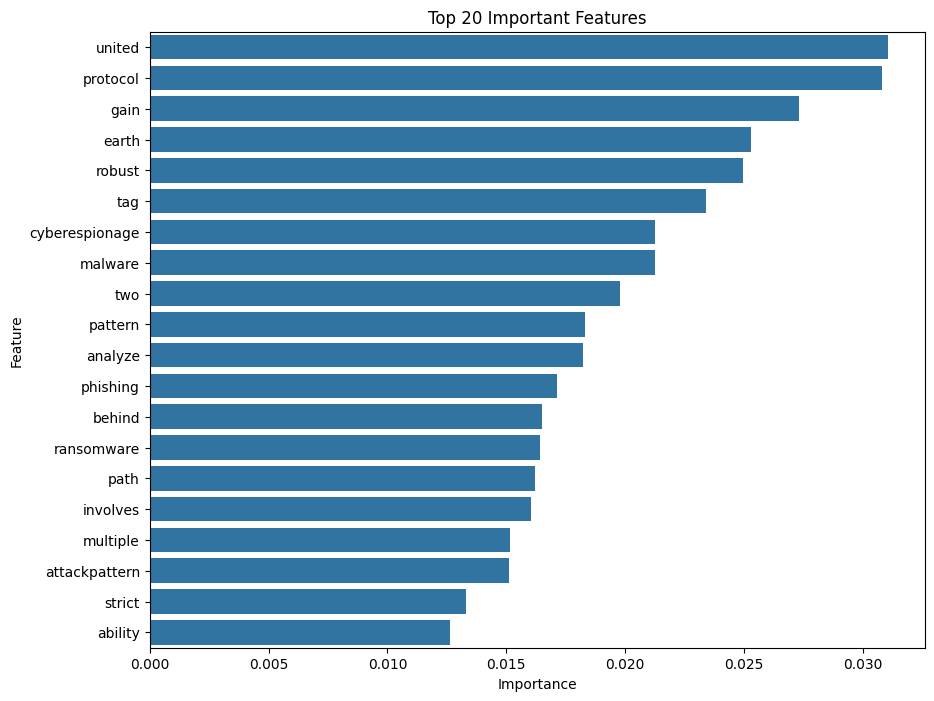

In [30]:
# For tree-based models (XGBoost or Random Forest)
feature_names = tfidf_vectorizer.get_feature_names_out().tolist() + \
                ['solution_count', 'text_length', 'diagnosis_length', 'solutions_length'] + \
                severity_encoded.columns.tolist()

# Get feature importances
importances = best_model.feature_importances_

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Important Features')
plt.show()

Model Deployment and Prediction
Once we've selected the best model, we can use it for predictions:

In [33]:
# Function to preprocess new data
def preprocess_new_data(text, diagnosis, solutions):
    # Clean text - rename the variables to avoid conflict with function name
    cleaned_text = clean_text(text)  # Changed variable name to cleaned_text
    cleaned_diagnosis = clean_text(diagnosis)  # Changed variable name to cleaned_diagnosis
    cleaned_solutions = clean_text(solutions)  # Changed variable name to cleaned_solutions

    # Combine text
    combined_text = cleaned_text + ' ' + cleaned_diagnosis + ' ' + cleaned_solutions

    # Lemmatize
    processed_text = lemmatize_text(combined_text)

    # Create features
    text_features = tfidf_vectorizer.transform([processed_text])
    solution_count = len(solutions.split('.')) - 1
    text_length = len(text)
    diagnosis_length = len(diagnosis)
    solutions_length = len(solutions)

    # Create severity feature
    severity = extract_severity(diagnosis)
    severity_encoded = pd.DataFrame(columns=['severity_high', 'severity_low', 'severity_medium'])
    severity_encoded.loc[0] = [0, 0, 0]  # Initialize with zeros
    severity_encoded[f'severity_{severity}'] = 1

    # Combine all features
    structured_features = np.array([[solution_count, text_length, diagnosis_length, solutions_length]])
    X_new = hstack([text_features, structured_features, severity_encoded])

    return X_new

# Example prediction
sample_text = "A new variant of the Emotet malware was detected spreading through malicious Word documents in phishing emails."
sample_diagnosis = "The malware uses macros in Word documents to download and execute payloads, creating backdoors in infected systems."
sample_solutions = "1. Disable macros in Office documents. 2. Implement email filtering to block malicious attachments. 3. Update endpoint protection software."
# Preprocess
X_new = preprocess_new_data(sample_text, sample_diagnosis, sample_solutions)

# Predict
prediction = best_model.predict(X_new)
prediction_proba = best_model.predict_proba(X_new)

# Decode prediction
predicted_class = label_encoder.inverse_transform(prediction)[0]
class_probabilities = dict(zip(label_encoder.classes_, prediction_proba[0]))

print(f"Predicted Threat Type: {predicted_class}")
print("Class Probabilities:")
for class_name, prob in class_probabilities.items():
    print(f"{class_name}: {prob:.4f}")

Predicted Threat Type: malware
Class Probabilities:
attack_pattern: 0.0001
malware: 0.9996
other: 0.0002
threat_actor: 0.0000
vulnerability: 0.0001
